In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['text.usetex'] = True
plt.rc('font', family = 'roman')

import SMBHBpy
from SMBHBpy import constants as c
from SMBHBpy import merger_system as ms

from scipy.interpolate import interp1d
import scipy.integrate as integrate
from matplotlib.colors import LogNorm

The code works in geometrized units with $c=G=1$, which means that energy, length, time, and mass all have the same units (see for example $E=mc^2 = m$, and $1 = c = \text{length}/\text{time}$)

We can choose which unit we want to describe them with, and usually parsecs is chosen ($1$ pc$\, \approx 3.26$ ly$\,\approx 3.09\cdot 10^{16}$ m). To this end, the SMBHBpy.constants file has a few constants for the transformation.

### Define the SMBH binary

In [2]:
m_array = np.array([1e5,1e7])*c.solar_mass_to_pc

z = 0.03

def D_L(z):
    hubble_const = 67.66 *1e-3*c.m_to_pc/c.s_to_pc                    # Hubble constant
    def E(z_):
        #https://arxiv.org/pdf/1807.06209.pdf
        omega_M = 0.3111                                              # Today’s matter (dark and baryonic) density                                       
        omega_Lambda = 1-omega_M                                      # Today's vacuum density (dark energy)
        return (omega_M*(1+z_)**3+omega_Lambda)**(-1/2)

    result, _ = integrate.quad(lambda x: E(x), 0, z)
    D_L = (1+z)/hubble_const * result                                 # Luminosity distance to the system from Earth [pc]
        
    return D_L
    
D_lum = D_L(z)

sigma = 200 *10**3*c.m_to_pc/(c.s_to_pc)       # Velocity dispersion of the host galaxy-bulge [km/s]
Coulomb_log = 10                               # Coulomb logarithm

### Define dark matter halo properties

In [3]:
# For equal-mass SMBHs!
# (https://arxiv.org/abs/1408.3534, https://arxiv.org/abs/1402.0005)

alpha_CDM = 7./3.
a_gamma = np.array([0,1,2,3,4])
alpha_SIDM_list = (3+a_gamma)/4

r_sp_array = np.array([0.2*m_array[0]/sigma**2, 0.2*m_array[1]/sigma**2])

rho_sp_CDM_array = np.array([(3-alpha_CDM)*0.2**(3-alpha_CDM)*m_array[0]/(2*np.pi*r_sp_array[0]**3), (3-alpha_CDM)*0.2**(3-alpha_CDM)*m_array[1]/(2*np.pi*r_sp_array[1]**3)])
rho_sp_SIDM_array = []
for j in range(len(alpha_SIDM_list)):
    rho_sp_SIDM_array.append([(3-alpha_SIDM_list[j])*0.2**(3-alpha_SIDM_list[j])*m_array[0]/(2*np.pi*r_sp_array[0]**3), (3-alpha_SIDM_list[j])*0.2**(3-alpha_SIDM_list[j])*m_array[1]/(2*np.pi*r_sp_array[1]**3)])

spike_CDM_list = [SMBHBpy.halo.Spike(rho_sp_CDM_array[0], r_sp_array[0], alpha_CDM), SMBHBpy.halo.Spike(rho_sp_CDM_array[1], r_sp_array[1], alpha_CDM)]
spike_SIDM_list = []
for j in range(len(alpha_SIDM_list)):
    spike_SIDM_list.append([SMBHBpy.halo.Spike(rho_sp_SIDM_array[j][0], r_sp_array[0], alpha_SIDM_list[j]), SMBHBpy.halo.Spike(rho_sp_SIDM_array[j][1], r_sp_array[1], alpha_SIDM_list[j])])
    

# For GW-only, i.e., no spikes around the SMBHs, for comparison
no_spike_GW = SMBHBpy.halo.ConstHalo(0.)

### Define initial conditions for a circular inspiral

In [4]:
# Create the SystemProp object describing the SMBH binary with static CDM halos
sp_CDM_list = [ms.SystemProp(m_array[0], m_array[0], spike_CDM_list[0], spike_CDM_list[0], sigma, Coulomb_log, D=D_lum, inclination_angle = np.pi/2),ms.SystemProp(m_array[1], m_array[1], spike_CDM_list[1], spike_CDM_list[1], sigma, Coulomb_log, D=D_lum, inclination_angle = np.pi/2)]
sp_list = [sp_CDM_list[0],sp_CDM_list[1]]

# Create the SystemProp object describing the SMBH binary with static SIDM halos (k = 0)
sp_SIDM_list = []
for j in range(len(alpha_SIDM_list)):
    sp_SIDM_list.append([ms.SystemProp(m_array[0], m_array[0], spike_SIDM_list[j][0], spike_SIDM_list[j][0], sigma, Coulomb_log, D=D_lum, inclination_angle = np.pi/2), ms.SystemProp(m_array[1], m_array[1], spike_SIDM_list[j][1], spike_SIDM_list[j][1], sigma, Coulomb_log, D=D_lum, inclination_angle = np.pi/2)])

# For GW-only, i.e., no spikes around the SMBHs, for comparison
sp_GW_list = [ms.SystemProp(m_array[0], m_array[0], no_spike_GW, no_spike_GW, sigma, Coulomb_log, D=D_lum, inclination_angle = np.pi/2),ms.SystemProp(m_array[1], m_array[1], no_spike_GW, no_spike_GW, sigma, Coulomb_log, D=D_lum, inclination_angle = np.pi/2)]

# Initial separartion
R0_array = np.array([50*(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()),50*(sp_list[1].r_isco_1()+sp_list[1].r_isco_2())])

# Final condition for evolution
R_fin_array = np.array([sp_list[0].r_isco_1()+sp_list[0].r_isco_2(),sp_list[1].r_isco_1()+sp_list[1].r_isco_2()])

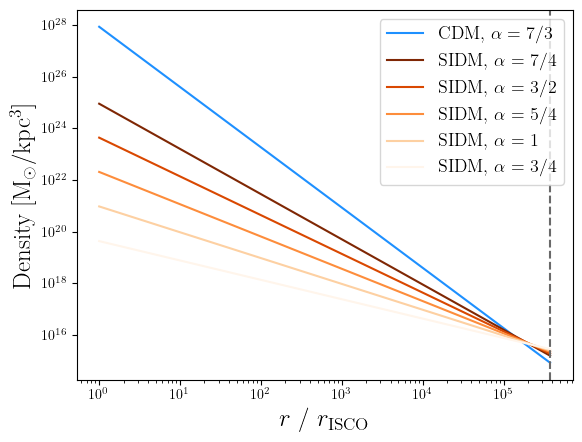

In [5]:
# Density profiles for different typs of matter
m = 1e7 * c.solar_mass_to_pc                           # Chose the mass of the SMBH
sigma = 200 *10**3*c.m_to_pc/(c.s_to_pc)
r_sp = 0.2*m/sigma**2
r_s = m/sigma**2
r_isco = 6*m
rho_sp_CDM = (3-7/3)*0.2**(3-7/3)*m/(2*np.pi*r_sp**3)
rho_sp_SIDM = (3-alpha_SIDM_list)*0.2**(3-alpha_SIDM_list)*m/(2*np.pi*r_sp**3)
alpha_label = ["3/4", "1", "5/4", "3/2", "7/4"]
#rho_s = 4*0.2**(7/3)*rho_sp_CDM
r_ = np.geomspace(r_isco, r_s, 1000)
rho_CDM = rho_sp_CDM * (r_sp/r_)**(7/3)
rho_SIDM = []
for j in range(len(alpha_SIDM_list)):
    rho_SIDM.append(rho_sp_SIDM[j] * (r_sp/r_)**(alpha_SIDM_list[j]))
#nfw = SMBHBpy.halo.NFW(rho_s, r_s)
#rho_NFW = nfw.density(r_)
plt.loglog(r_/r_isco, rho_CDM/c.solar_mass_to_pc*1e9, label=r'CDM, $\alpha = 7/3$', color = "dodgerblue")
n_sidm = len(alpha_SIDM_list)
orange_cmap = matplotlib.colormaps['Oranges'].resampled(n_sidm)
orange_colors = orange_cmap(np.linspace(0.1, 0.95, n_sidm))
for j in range(len(alpha_SIDM_list) - 1, -1, -1):
    plt.loglog(r_/r_isco, rho_SIDM[j]/c.solar_mass_to_pc*1e9, label=r'SIDM, $\alpha = $'+f' {alpha_label[j]}', color = orange_colors[j])
#plt.loglog(r_/r_isco, rho_NFW/c.solar_mass_to_pc*1e9, label='NFW halo', color = "darkgreen")
plt.axvline(x=r_s/r_isco, linestyle='--', color = "dimgrey")
plt.legend(loc='upper right', fontsize=13)
plt.xlabel(r"$r$ / $r_\mathrm{ISCO}$", fontsize=18); plt.ylabel(r"Density [$\mathrm{M_\odot}$/kpc$^3$]", fontsize=18)
#plt.suptitle(r"$m_\mathrm{BH} = 10^7\,\mathrm{M_\odot}$", y=0.95, fontsize=16)    
plt.show()

### Solve the differential equations for circular orbits

In [6]:
opt_ev = SMBHBpy.inspiral.Classic.EvolutionOptions(accuracy=1e-14)

# Solve the differential equations for static CDM halos
ev_CDM_list = [SMBHBpy.inspiral.Classic.Evolve(sp_CDM_list[0], R0_array[0], a_fin = R_fin_array[0], opt = opt_ev),SMBHBpy.inspiral.Classic.Evolve(sp_CDM_list[1], R0_array[1], a_fin = R_fin_array[1], opt = opt_ev)]

# Solve the differential equations for static SIDM halos
fix_slope_index = 4      # slope of SIDM spike is fixed to limiting case of 7/4
ev_SIDM_list = [SMBHBpy.inspiral.Classic.Evolve(sp_SIDM_list[fix_slope_index][0], R0_array[0], a_fin = R_fin_array[0], opt = opt_ev),SMBHBpy.inspiral.Classic.Evolve(sp_SIDM_list[fix_slope_index][1], R0_array[1], a_fin = R_fin_array[1], opt = opt_ev)]

# For GW-only, i.e., no spikes around the SMBHs, for comparison
ev_GW_list = [SMBHBpy.inspiral.Classic.Evolve(sp_GW_list[0], R0_array[0], a_fin = R_fin_array[0], opt = opt_ev),SMBHBpy.inspiral.Classic.Evolve(sp_GW_list[1], R0_array[1], a_fin = R_fin_array[1], opt = opt_ev)]

Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-14
A termination event occurred.
 -> Evolution took 0.1332s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-14


C:\Users\matthias\Anaconda\lib\site-packages\scipy\integrate\_ivp\ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


A termination event occurred.
 -> Evolution took 0.1311s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-14
A termination event occurred.
 -> Evolution took 0.2387s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-14
A termination event occurred.
 -> Evolution took 0.2291s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-14
A termination event occurred.
 -> Evolution took 0.3249s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-14
A termination event occurred.
 -> Evolution took 0.3264s


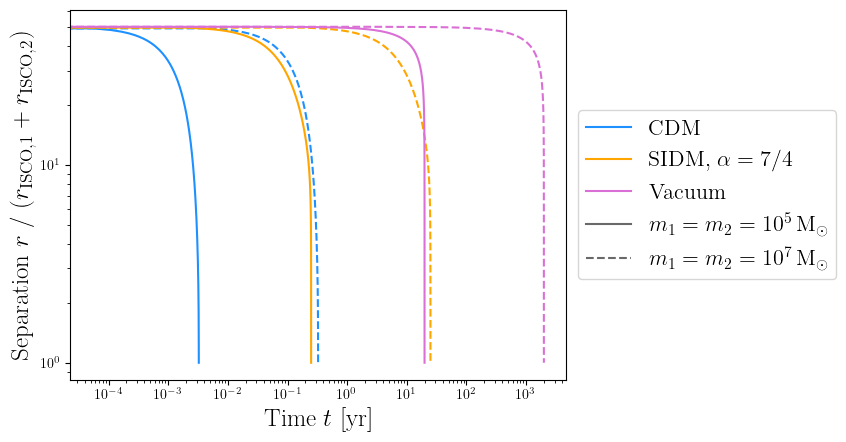

In [7]:
# Plot the results (r vs. t)
fig, ax1 = plt.subplots()
ax1.loglog(ev_CDM_list[0].t/c.year_to_pc, ev_CDM_list[0].R/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), label = "CDM", color = "dodgerblue")
ax1.loglog(ev_CDM_list[1].t/c.year_to_pc, ev_CDM_list[1].R/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), color = "dodgerblue", linestyle = "dashed")
ax1.loglog(ev_SIDM_list[0].t/c.year_to_pc, ev_SIDM_list[0].R/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), label = r"SIDM, $\alpha = 7/4$", color = "orange")
ax1.loglog(ev_SIDM_list[1].t/c.year_to_pc, ev_SIDM_list[1].R/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), color = "orange", linestyle = "dashed")
ax1.loglog(ev_GW_list[0].t/c.year_to_pc, ev_GW_list[0].R/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), label = "Vacuum", color = "orchid")
ax1.loglog(ev_GW_list[1].t/c.year_to_pc, ev_GW_list[1].R/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), color = "orchid", linestyle = "dashed")
ax1.loglog(1e1, 1e1, label=r"$m_1 = m_2 = 10^5 \, \mathrm{M_{\odot}}$ ", linestyle="solid", color="dimgrey")
ax1.loglog(1e1, 1e1, label=r"$m_1 = m_2 = 10^7 \, \mathrm{M_{\odot}}$ ", linestyle="dashed", color="dimgrey")
ax1.set_xlabel("Time $t$ [yr]", fontsize=18); ax1.set_ylabel("Separation $r$ / ($r_{\mathrm{ISCO,1}}+r_{\mathrm{ISCO,2}}$)", fontsize=18)

# Add spectrogram to the same figure (f_obs vs. t)
#ax2 = ax1.twinx()
#ax2.loglog(ev_CDM_list[0].t/c.year_to_pc, np.sqrt(sp_list[0].m_total()/(ev_CDM_list[0].R)**3)/np.pi/c.hz_to_invpc, label = "CDM", color = "dodgerblue", alpha = 0.3)
#ax2.loglog(ev_CDM_list[1].t/c.year_to_pc, np.sqrt(sp_list[1].m_total()/(ev_CDM_list[1].R)**3)/np.pi/c.hz_to_invpc, color = "dodgerblue", linestyle = "dashed", alpha = 0.3)
#ax2.loglog(ev_SIDM_list[0].t/c.year_to_pc, np.sqrt(sp_list[0].m_total()/(ev_SIDM_list[0].R)**3)/np.pi/c.hz_to_invpc, label = r"SIDM, $\alpha = 7/4$", color = "orange", alpha = 0.3)
#ax2.loglog(ev_SIDM_list[1].t/c.year_to_pc, np.sqrt(sp_list[1].m_total()/(ev_SIDM_list[1].R)**3)/np.pi/c.hz_to_invpc, color = "orange", linestyle = "dashed", alpha = 0.3)
#ax2.loglog(ev_GW_list[0].t/c.year_to_pc, np.sqrt(sp_list[0].m_total()/(ev_GW_list[0].R)**3)/np.pi/c.hz_to_invpc, label = "Vacuum", color = "orchid", alpha = 0.3)
#ax2.loglog(ev_GW_list[1].t/c.year_to_pc, np.sqrt(sp_list[1].m_total()/(ev_GW_list[1].R)**3)/np.pi/c.hz_to_invpc, color = "orchid", linestyle = "dashed", alpha = 0.3)
#ax2.set_ylabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=18, color="black", alpha = 0.3)

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
#ax1.legend(loc='center left', bbox_to_anchor=(1.17, 0.5), fontsize=16)                    # When spectrogram is included
#plt.savefig("r_vs_t_with_spectrogram.png", dpi = 300, bbox_inches='tight')
plt.show()

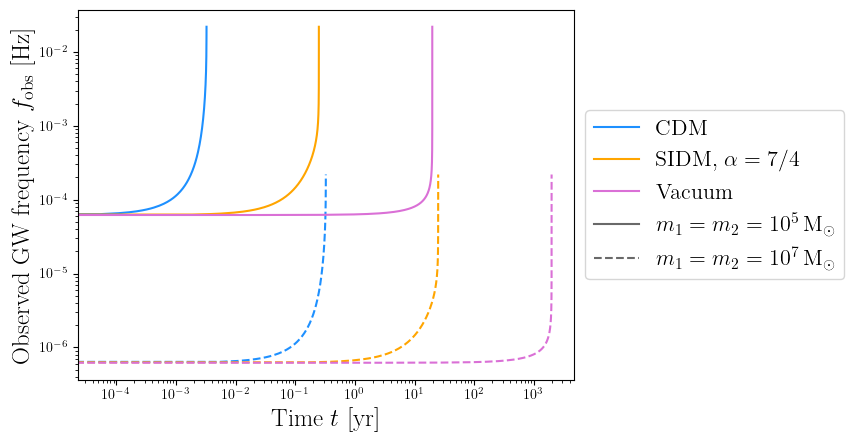

In [8]:
# Spectrogram (f_obs vs. t) for the circular case
plt.loglog(ev_CDM_list[0].t/c.year_to_pc, np.sqrt(sp_list[0].m_total()/(ev_CDM_list[0].R)**3)/np.pi/c.hz_to_invpc, label = "CDM", color = "dodgerblue")
plt.loglog(ev_CDM_list[1].t/c.year_to_pc, np.sqrt(sp_list[1].m_total()/(ev_CDM_list[1].R)**3)/np.pi/c.hz_to_invpc, color = "dodgerblue", linestyle = "dashed")
plt.loglog(ev_SIDM_list[0].t/c.year_to_pc, np.sqrt(sp_list[0].m_total()/(ev_SIDM_list[0].R)**3)/np.pi/c.hz_to_invpc, label = r"SIDM, $\alpha = 7/4$", color = "orange")
plt.loglog(ev_SIDM_list[1].t/c.year_to_pc, np.sqrt(sp_list[1].m_total()/(ev_SIDM_list[1].R)**3)/np.pi/c.hz_to_invpc, color = "orange", linestyle = "dashed")
plt.loglog(ev_GW_list[0].t/c.year_to_pc, np.sqrt(sp_list[0].m_total()/(ev_GW_list[0].R)**3)/np.pi/c.hz_to_invpc, label = "Vacuum", color = "orchid")
plt.loglog(ev_GW_list[1].t/c.year_to_pc, np.sqrt(sp_list[1].m_total()/(ev_GW_list[1].R)**3)/np.pi/c.hz_to_invpc, color = "orchid", linestyle = "dashed")
plt.xlabel("Time $t$ [yr]", fontsize=18); plt.ylabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=18)

plt.loglog(1e1, 1e-3, label=r"$m_1 = m_2 = 10^5 \, \mathrm{M_{\odot}}$ ", linestyle="solid", color="dimgrey")
plt.loglog(1e1, 1e-3, label=r"$m_1 = m_2 = 10^7 \, \mathrm{M_{\odot}}$ ", linestyle="dashed", color="dimgrey")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
#plt.savefig("f_obs_vs_t_circular.png", dpi = 300, bbox_inches='tight')
plt.show()

# Calculate GW signal

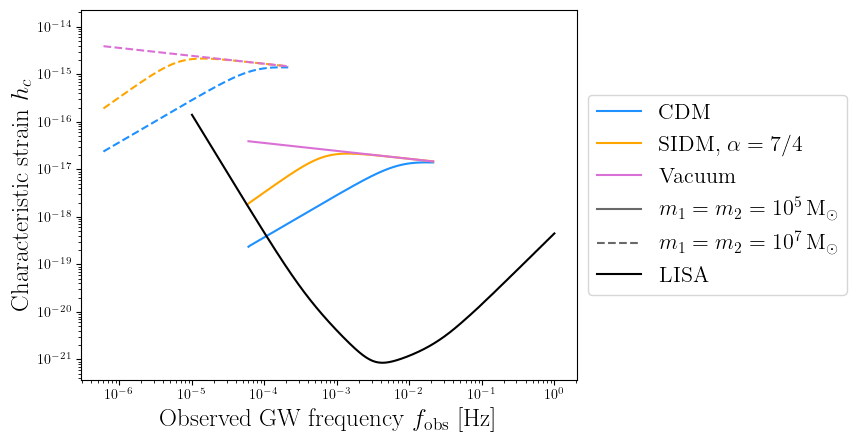

In [9]:
# The characteristic strain of the different GW signals compared to LISA's sensitivity curve

# CDM spikes:
f_gw_CDM_0, h_2_plus_CDM_0, h_2_cross_CDM_0, N_CDM_0 = SMBHBpy.waveform.h_2(sp_CDM_list[0], ev_CDM_list[0])
f_gw_CDM_1, h_2_plus_CDM_1, h_2_cross_CDM_1, N_CDM_1 = SMBHBpy.waveform.h_2(sp_CDM_list[1], ev_CDM_list[1])
plt.loglog(f_gw_CDM_0/c.hz_to_invpc, 2.* f_gw_CDM_0*h_2_plus_CDM_0, label="CDM", color = "dodgerblue")
plt.loglog(f_gw_CDM_1/c.hz_to_invpc, 2.* f_gw_CDM_1*h_2_plus_CDM_1, color = "dodgerblue", linestyle = "dashed")

# SIDM spikes:
f_gw_SIDM_0, h_2_plus_SIDM_0, h_2_cross_SIDM_0, N_SIDM_0 = SMBHBpy.waveform.h_2(sp_SIDM_list[fix_slope_index][0], ev_SIDM_list[0])
f_gw_SIDM_1, h_2_plus_SIDM_1, h_2_cross_SIDM_1, N_SIDM_1 = SMBHBpy.waveform.h_2(sp_SIDM_list[fix_slope_index][1], ev_SIDM_list[1])
plt.loglog(f_gw_SIDM_0/c.hz_to_invpc, 2.* f_gw_SIDM_0*h_2_plus_SIDM_0, label=r"SIDM, $\alpha = 7/4$", color = "orange")
plt.loglog(f_gw_SIDM_1/c.hz_to_invpc, 2.* f_gw_SIDM_1*h_2_plus_SIDM_1, color = "orange", linestyle = "dashed")

# For GW-only, i.e. no spikes around the SMBHs, for comparison
f_gw_GW_0, h_2_plus_GW_0, h_2_cross_GW_0, N_GW_0 = SMBHBpy.waveform.h_2(sp_GW_list[0], ev_GW_list[0])
f_gw_GW_1, h_2_plus_GW_1, h_2_cross_GW_1, N_GW_1 = SMBHBpy.waveform.h_2(sp_GW_list[1], ev_GW_list[1])
plt.loglog(f_gw_GW_0/c.hz_to_invpc, 2.* f_gw_GW_0*h_2_plus_GW_0, label="Vacuum", color = "orchid")
plt.loglog(f_gw_GW_1/c.hz_to_invpc, 2.* f_gw_GW_1*h_2_plus_GW_1, color = "orchid", linestyle = "dashed")

plt.loglog(1e-5, 1e-14, label=r"$m_1 = m_2 = 10^5 \, \mathrm{M_\odot}$ ", linestyle="solid", color="dimgrey")
plt.loglog(1e-5, 1e-14, label=r"$m_1 = m_2 = 10^7 \, \mathrm{M_\odot}$ ", linestyle="dashed", color="dimgrey")

# LISA (https://arxiv.org/pdf/1803.01944)
Lisa = SMBHBpy.detector.Lisa()
f_gw_LISA = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 1000)
plt.loglog(f_gw_LISA/c.hz_to_invpc, Lisa.NoiseStrain(f_gw_LISA), label='LISA', color = "black", linestyle="solid")

plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=18); plt.ylabel("Characteristic strain $h_c$", fontsize=18)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
plt.show()

## Dephasing - difference in the number of GW cycles with and without DM

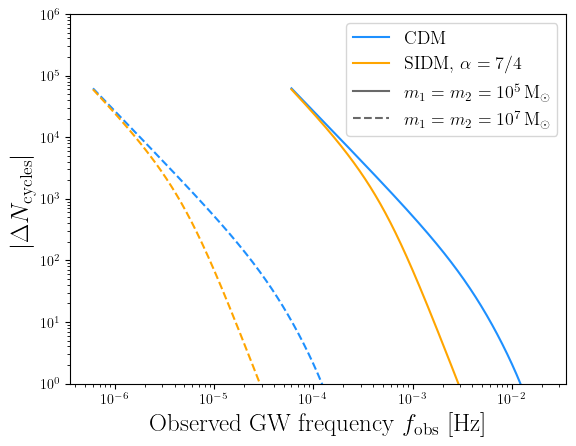

In [10]:
# Steps to ensure that all N_cycles are defined on the same f_obs range for both masses
f_common_0 = np.logspace(
    np.log10(max(f_gw_CDM_0.min(), f_gw_SIDM_0.min(), f_gw_GW_0.min())),
    np.log10(min(f_gw_CDM_0.max(), f_gw_SIDM_0.max(), f_gw_GW_0.max())),
    500
)
f_common_1 = np.logspace(
    np.log10(max(f_gw_CDM_1.min(), f_gw_SIDM_1.min(), f_gw_GW_1.min())),
    np.log10(min(f_gw_CDM_1.max(), f_gw_SIDM_1.max(), f_gw_GW_1.max())),
    500
)

interp_CDM_0 = interp1d(f_gw_CDM_0, N_CDM_0, kind='cubic', bounds_error=False, fill_value=np.nan)
interp_SIDM_0 = interp1d(f_gw_SIDM_0, N_SIDM_0, kind='cubic', bounds_error=False, fill_value=np.nan)
interp_GW_0 = interp1d(f_gw_GW_0, N_GW_0, kind='cubic', bounds_error=False, fill_value=np.nan)

interp_CDM_1 = interp1d(f_gw_CDM_1, N_CDM_1, kind='cubic', bounds_error=False, fill_value=np.nan)
interp_SIDM_1 = interp1d(f_gw_SIDM_1, N_SIDM_1, kind='cubic', bounds_error=False, fill_value=np.nan)
interp_GW_1 = interp1d(f_gw_GW_1, N_GW_1, kind='cubic', bounds_error=False, fill_value=np.nan)

N_CDM_0_i  = interp_CDM_0(f_common_0)
N_SIDM_0_i = interp_SIDM_0(f_common_0)
N_GW_0_i   = interp_GW_0(f_common_0)

N_CDM_1_i  = interp_CDM_1(f_common_1)
N_SIDM_1_i = interp_SIDM_1(f_common_1)
N_GW_1_i   = interp_GW_1(f_common_1)

# Plot dephasing = Delta N_cycles
plt.loglog(f_common_0 / c.hz_to_invpc, N_GW_0_i-N_CDM_0_i, label="CDM", color="dodgerblue")
plt.loglog(f_common_1 / c.hz_to_invpc, N_GW_1_i-N_CDM_1_i, color="dodgerblue", linestyle="dashed")

plt.loglog(f_common_0 / c.hz_to_invpc, N_GW_0_i-N_SIDM_0_i, label=r"SIDM, $\alpha = 7/4$", color="orange")
plt.loglog(f_common_1 / c.hz_to_invpc, N_GW_1_i-N_SIDM_1_i, color="orange", linestyle="dashed")

plt.loglog(1e-5, 1e-4, label=r"$m_1 = m_2 = 10^5 \, \mathrm{M_\odot}$ ", linestyle="solid", color="dimgrey")
plt.loglog(1e-5, 1e-4, label=r"$m_1 = m_2 = 10^7 \, \mathrm{M_\odot}$ ", linestyle="dashed", color="dimgrey")

plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=18); plt.ylabel("$|\Delta N_\mathrm{cycles}|$", fontsize=18)

plt.legend(loc='upper right', fontsize=13)
plt.ylim(1e0,1e6)
#plt.savefig("Dephasing_CDM_and_SIDM.png", dpi = 300, bbox_inches='tight')
plt.show()

# Energy loss as a function of $f_\mathrm{obs}$

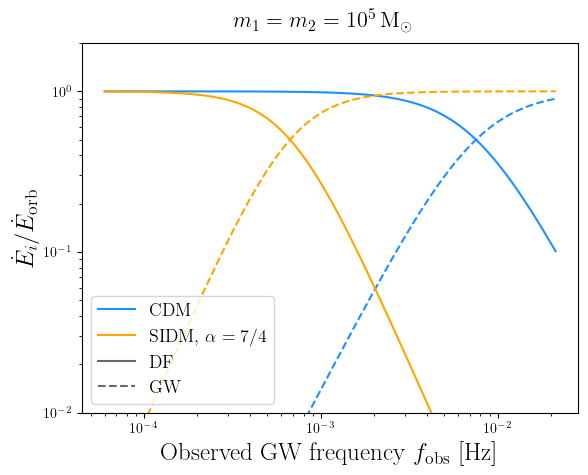

In [11]:
# Get values for the different energy losses over time (for circular orbits)
from SMBHBpy.inspiral.forces import GWLoss
from SMBHBpy.inspiral.forces import DynamicalFriction
gw_loss = GWLoss()
df_loss = DynamicalFriction()

CDM_DF_list = [df_loss.dE_dt(sp_CDM_list[0], ev_CDM_list[0].R, 0, opt = opt_ev), df_loss.dE_dt(sp_CDM_list[1], ev_CDM_list[1].R, 0, opt = opt_ev)]
CDM_GW_list = [gw_loss.dE_dt(sp_CDM_list[0], ev_CDM_list[0].R, 0, opt = opt_ev), gw_loss.dE_dt(sp_CDM_list[1], ev_CDM_list[1].R, 0, opt = opt_ev)]
SIDM_DF_list = [df_loss.dE_dt(sp_SIDM_list[fix_slope_index][0], ev_SIDM_list[0].R, 0, opt = opt_ev), df_loss.dE_dt(sp_SIDM_list[fix_slope_index][1], ev_SIDM_list[1].R, 0, opt = opt_ev)]
SIDM_GW_list = [gw_loss.dE_dt(sp_SIDM_list[fix_slope_index][0], ev_SIDM_list[0].R, 0, opt = opt_ev), gw_loss.dE_dt(sp_SIDM_list[fix_slope_index][1], ev_SIDM_list[1].R, 0, opt = opt_ev)]

# CDM spikes:
plt.loglog(f_gw_CDM_0/c.hz_to_invpc, CDM_DF_list[0]/(CDM_DF_list[0]+CDM_GW_list[0]), label="CDM", color = "dodgerblue")
plt.loglog(f_gw_CDM_0/c.hz_to_invpc, CDM_GW_list[0]/(CDM_DF_list[0]+CDM_GW_list[0]), color = "dodgerblue", linestyle = "dashed")
#plt.loglog(f_gw_CDM_1/c.hz_to_invpc, CDM_DF_list[1]/(CDM_DF_list[1]+CDM_GW_list[1]), color = "dodgerblue", linestyle = "dashed")
#plt.loglog(f_gw_CDM_1/c.hz_to_invpc, CDM_GW_list[1]/(CDM_DF_list[1]+CDM_GW_list[1]), color = "dodgerblue", linestyle = "dashed", alpha = 0.3)

# SIDM spikes:
plt.loglog(f_gw_SIDM_0/c.hz_to_invpc, SIDM_DF_list[0]/(SIDM_DF_list[0]+SIDM_GW_list[0]), label=r"SIDM, $\alpha = 7/4$", color = "orange")
plt.loglog(f_gw_SIDM_0/c.hz_to_invpc, SIDM_GW_list[0]/(SIDM_DF_list[0]+SIDM_GW_list[0]), color = "orange", linestyle = "dashed")
#plt.loglog(f_gw_SIDM_1/c.hz_to_invpc, SIDM_DF_list[1]/(SIDM_DF_list[1]+SIDM_GW_list[1]), color = "orange", linestyle = "dashed")
#plt.loglog(f_gw_SIDM_1/c.hz_to_invpc, SIDM_GW_list[1]/(SIDM_DF_list[1]+SIDM_GW_list[1]), color = "orange", linestyle = "dashed", alpha = 0.3)

plt.loglog(1e-3, 1e-1, label=r"DF", linestyle="solid", color="dimgrey")
plt.loglog(1e-3, 1e-1, label=r"GW", linestyle="dashed", color="dimgrey")

plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=18); plt.ylabel("$\dot{E}_i/\dot{E}_\mathrm{orb}$", fontsize=18)
plt.ylim(1e-2,2)

plt.suptitle("$m_1 = m_2 = 10^5 \, \mathrm{M_\odot}$", y=0.95, fontsize=16)
plt.legend(loc='lower left', fontsize=13)
#plt.savefig("EnergyLoss_m_1e5.png", dpi = 300, bbox_inches='tight')
plt.show()

### Do the same for eccentric inspirals

In [12]:
opt_ev_ecc = SMBHBpy.inspiral.Classic.EvolutionOptions(accuracy=1e-11)
a0_array = np.array([50*(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()),50*(sp_list[1].r_isco_1()+sp_list[1].r_isco_2())])
a_fin_array = np.array([sp_list[0].r_isco_1()+sp_list[0].r_isco_2(),sp_list[1].r_isco_1()+sp_list[1].r_isco_2()])
e0 = np.array([0.25, 0.5, 0.75])



ev_ecc_CDM = []
ev_ecc_SIDM = []

for i in e0:
    ev_ecc_CDM.append(SMBHBpy.inspiral.Classic.Evolve(sp_CDM_list[0], a0_array[0], e_0=i,  a_fin = a_fin_array[0], opt = opt_ev_ecc))
    ev_ecc_CDM.append(SMBHBpy.inspiral.Classic.Evolve(sp_CDM_list[1], a0_array[1], e_0=i,  a_fin = a_fin_array[1], opt = opt_ev_ecc))
    ev_ecc_SIDM.append(SMBHBpy.inspiral.Classic.Evolve(sp_SIDM_list[fix_slope_index][0], a0_array[0], e_0=i,  a_fin = a_fin_array[0], opt = opt_ev_ecc))
    ev_ecc_SIDM.append(SMBHBpy.inspiral.Classic.Evolve(sp_SIDM_list[fix_slope_index][1], a0_array[1], e_0=i,  a_fin = a_fin_array[1], opt = opt_ev_ecc))

Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.25  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11
A termination event occurred.
 -> Evolution took 3.3022s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.25  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11
A termination event occurred.
 -> Evolution took 3.5198s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.25  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11
A termination event occurred.
 -> Evolution took 3.2309s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.25  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11
A termination event occurred.
 -> Evolution took 3.1444s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.5  with 

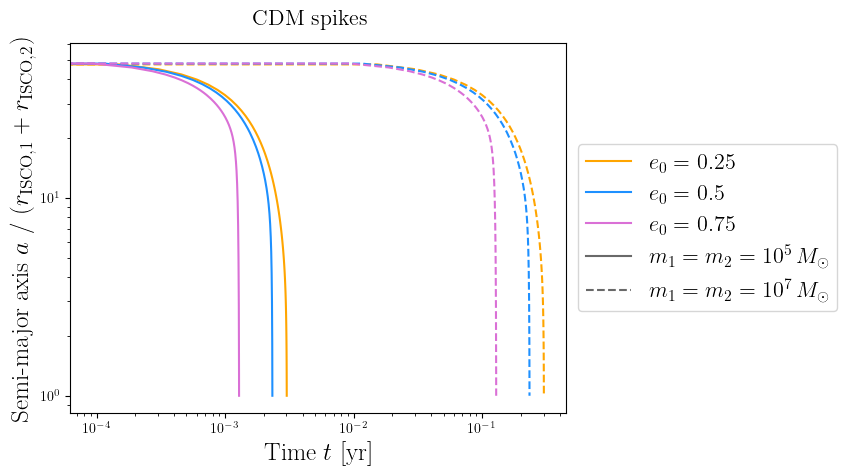

In [13]:
# Plot the results for CDM

color_list = ["orange","dodgerblue","orchid"]             # Color list: Must have the same size as the array for e0

for i in range(len(e0)):
    plt.loglog(ev_ecc_CDM[2*i].t/c.year_to_pc, ev_ecc_CDM[2*i].a/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), label = '$e_0 = $ ' + str(e0[i]), color = color_list[i])
    plt.loglog(ev_ecc_CDM[2*i+1].t/c.year_to_pc, ev_ecc_CDM[2*i+1].a/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), linestyle = "dashed", color = color_list[i])

plt.loglog(1e-1, 1e1, label=r"$m_1 = m_2 = 10^5 \, M_{\odot}$ ", linestyle="solid", color="dimgrey")
plt.loglog(1e-1, 1e1, label=r"$m_1 = m_2 = 10^7 \, M_{\odot}$ ", linestyle="dashed", color="dimgrey")

plt.suptitle("CDM spikes", y=0.95, fontsize=16)    
plt.legend(loc="center left",  bbox_to_anchor=(1, 0.5), fontsize=16)
plt.xlabel("Time $t$ [yr]", fontsize=18); plt.ylabel("Semi-major axis $a$ / ($r_{\mathrm{ISCO,1}}+r_{\mathrm{ISCO,2}}$)", fontsize=18)
plt.show()

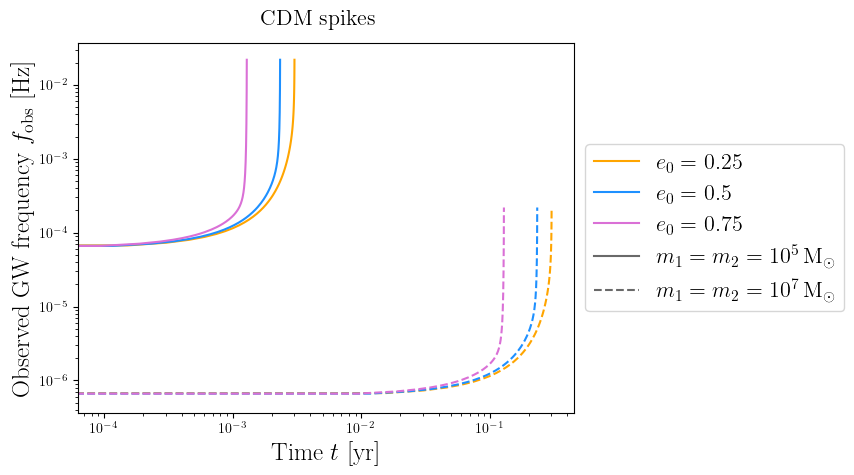

In [14]:
# Spectrogram (f_obs vs. t) for CDM spikes (restricted to second harmonic, i.e. f_obs = 2*f_orb)
for i in range(len(e0)):
    plt.loglog(ev_ecc_CDM[2*i].t/c.year_to_pc, np.sqrt(sp_list[0].m_total()/(ev_ecc_CDM[2*i].a)**3)/np.pi/c.hz_to_invpc, label = '$e_0 = $ ' + str(e0[i]), color = color_list[i])
    plt.loglog(ev_ecc_CDM[2*i+1].t/c.year_to_pc, np.sqrt(sp_list[1].m_total()/(ev_ecc_CDM[2*i+1].a)**3)/np.pi/c.hz_to_invpc, color = color_list[i], linestyle = "dashed")

plt.xlabel("Time $t$ [yr]", fontsize=18); plt.ylabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=18)

plt.loglog(1e-1, 1e-3, label=r"$m_1 = m_2 = 10^5 \, \mathrm{M_{\odot}}$ ", linestyle="solid", color="dimgrey")
plt.loglog(1e-1, 1e-3, label=r"$m_1 = m_2 = 10^7 \, \mathrm{M_{\odot}}$ ", linestyle="dashed", color="dimgrey")

plt.suptitle(r"CDM spikes", y=0.95, fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
#plt.savefig("spectrogram_eccentric_CDM.png", dpi = 300, bbox_inches='tight')
plt.show()

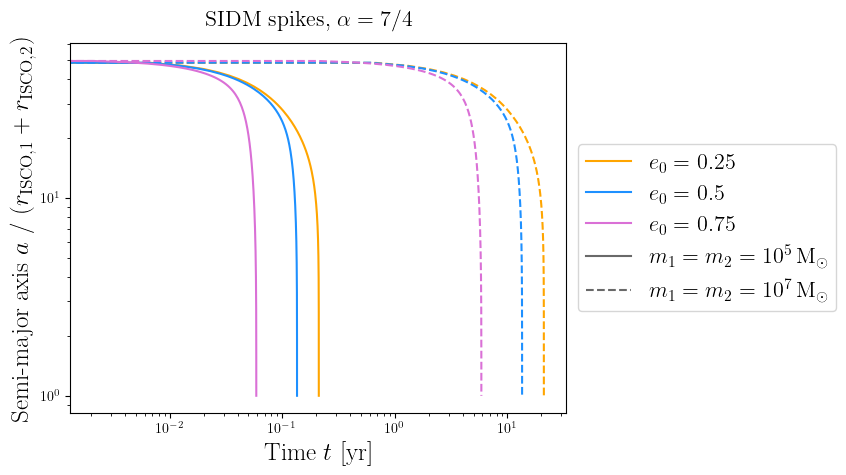

In [15]:
# Plot the results for SIDM

for i in range(len(e0)):
    plt.loglog(ev_ecc_SIDM[2*i].t/c.year_to_pc, ev_ecc_SIDM[2*i].a/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), label = '$e_0 = $ ' + str(e0[i]), color = color_list[i])
    plt.loglog(ev_ecc_SIDM[2*i+1].t/c.year_to_pc, ev_ecc_SIDM[2*i+1].a/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), linestyle = "dashed", color = color_list[i])
    
plt.loglog(1e1, 1e1, label=r"$m_1 = m_2 = 10^5 \, \mathrm{M_\odot}$ ", linestyle="solid", color="dimgrey")
plt.loglog(1e1, 1e1, label=r"$m_1 = m_2 = 10^7 \, \mathrm{M_\odot}$ ", linestyle="dashed", color="dimgrey") 

plt.suptitle(r"SIDM spikes, $\alpha = 7/4$", y=0.95, fontsize=16)  
plt.legend(loc="center left",  bbox_to_anchor=(1, 0.5), fontsize=16); plt.xlabel("Time $t$ [yr]", fontsize=18); plt.ylabel("Semi-major axis $a$ / ($r_{\mathrm{ISCO,1}}+r_{\mathrm{ISCO,2}}$)", fontsize=18)
plt.show()

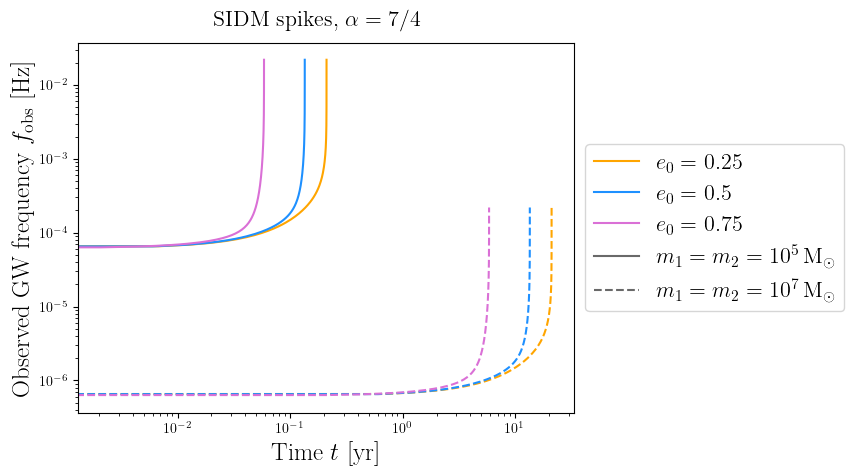

In [16]:
# Spectrogram (f_obs vs. t) for SIDM spikes (restricted to second harmonic, i.e. f_obs = 2*f_orb)
for i in range(len(e0)):
    plt.loglog(ev_ecc_SIDM[2*i].t/c.year_to_pc, np.sqrt(sp_list[0].m_total()/(ev_ecc_SIDM[2*i].a)**3)/np.pi/c.hz_to_invpc, label = '$e_0 = $ ' + str(e0[i]), color = color_list[i])
    plt.loglog(ev_ecc_SIDM[2*i+1].t/c.year_to_pc, np.sqrt(sp_list[1].m_total()/(ev_ecc_SIDM[2*i+1].a)**3)/np.pi/c.hz_to_invpc, color = color_list[i], linestyle = "dashed")

plt.xlabel("Time $t$ [yr]", fontsize=18); plt.ylabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=18)

plt.loglog(1e-1, 1e-3, label=r"$m_1 = m_2 = 10^5 \, \mathrm{M_{\odot}}$ ", linestyle="solid", color="dimgrey")
plt.loglog(1e-1, 1e-3, label=r"$m_1 = m_2 = 10^7 \, \mathrm{M_{\odot}}$ ", linestyle="dashed", color="dimgrey")

plt.suptitle(r"SIDM spikes, $\alpha = 7/4$", y=0.95, fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
#plt.savefig("spectrogram_eccentric_SIDM.png", dpi = 300, bbox_inches='tight')
plt.show()

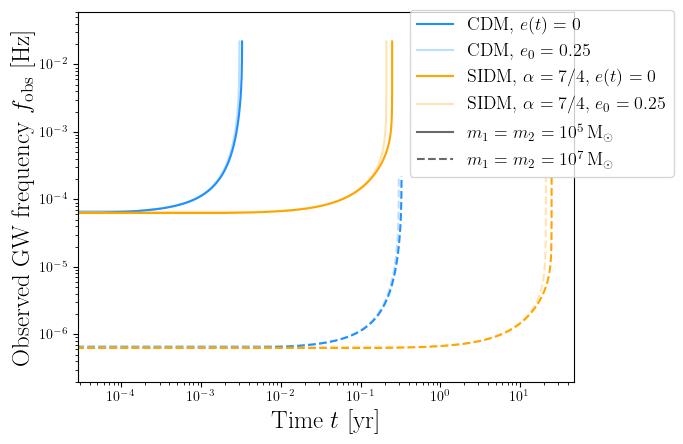

In [17]:
# Spectrogram (f_obs vs. t) for a fixed initial eccentricity + circular case and SIDM vs. CDM (restricted to second harmonic, i.e. f_obs = 2*f_orb)
fixed_e0 = int(0)                   # fix eccentricity -> e_0 = 0.25

plt.loglog(ev_CDM_list[0].t/c.year_to_pc, np.sqrt(sp_list[0].m_total()/(ev_CDM_list[0].R)**3)/np.pi/c.hz_to_invpc, label = "CDM, $e(t) = 0$", color = "dodgerblue")
plt.loglog(ev_CDM_list[1].t/c.year_to_pc, np.sqrt(sp_list[1].m_total()/(ev_CDM_list[1].R)**3)/np.pi/c.hz_to_invpc, color = "dodgerblue", linestyle = "dashed")
plt.loglog(ev_ecc_CDM[2*fixed_e0].t/c.year_to_pc, np.sqrt(sp_list[0].m_total()/(ev_ecc_CDM[2*fixed_e0].a)**3)/np.pi/c.hz_to_invpc, label = "CDM, $e_0 = 0.25$", color = "dodgerblue", alpha = 0.3)
plt.loglog(ev_ecc_CDM[2*fixed_e0+1].t/c.year_to_pc, np.sqrt(sp_list[1].m_total()/(ev_ecc_CDM[2*fixed_e0+1].a)**3)/np.pi/c.hz_to_invpc, color = "dodgerblue", linestyle = "dashed", alpha = 0.3)

plt.loglog(ev_SIDM_list[0].t/c.year_to_pc, np.sqrt(sp_list[0].m_total()/(ev_SIDM_list[0].R)**3)/np.pi/c.hz_to_invpc, label = r"SIDM, $\alpha = 7/4$, $e(t) = 0$", color = "orange")
plt.loglog(ev_SIDM_list[1].t/c.year_to_pc, np.sqrt(sp_list[1].m_total()/(ev_SIDM_list[1].R)**3)/np.pi/c.hz_to_invpc, color = "orange", linestyle = "dashed")
plt.loglog(ev_ecc_SIDM[2*fixed_e0].t/c.year_to_pc, np.sqrt(sp_list[0].m_total()/(ev_ecc_SIDM[2*fixed_e0].a)**3)/np.pi/c.hz_to_invpc, label = r"SIDM, $\alpha = 7/4$, $e_0 = 0.25$", color = "orange", alpha = 0.3)
plt.loglog(ev_ecc_SIDM[2*fixed_e0+1].t/c.year_to_pc, np.sqrt(sp_list[1].m_total()/(ev_ecc_SIDM[2*fixed_e0+1].a)**3)/np.pi/c.hz_to_invpc, color = "orange", linestyle = "dashed", alpha = 0.3)

plt.xlabel("Time $t$ [yr]", fontsize=18); plt.ylabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=18)

plt.loglog(1e-1, 1e-3, label=r"$m_1 = m_2 = 10^5 \, \mathrm{M_{\odot}}$ ", linestyle="solid", color="dimgrey")
plt.loglog(1e-1, 1e-3, label=r"$m_1 = m_2 = 10^7 \, \mathrm{M_{\odot}}$ ", linestyle="dashed", color="dimgrey")

#plt.suptitle(r"$e_0 = 0.25$", y=0.95, fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(0.65, 0.78), fontsize=13)
plt.ylim(2*1e-7, 6*1e-2)
#plt.savefig("spectrogram_e0_025+circular_CDM_vs_SIDM.png", dpi = 300, bbox_inches='tight')
plt.show()

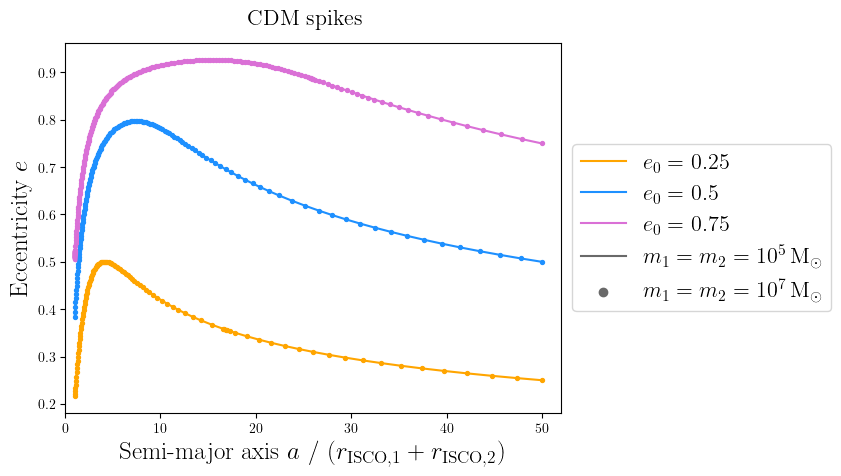

In [18]:
# Plot eccentricity vs. semi-major axis for CDM
for i in range(len(e0)):
    plt.plot(ev_ecc_CDM[2*i].a/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), ev_ecc_CDM[2*i].e, label = '$e_0 = $ ' + str(e0[i]), color = color_list[i])
    plt.scatter(ev_ecc_CDM[2*i+1].a/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), ev_ecc_CDM[2*i+1].e, color = color_list[i], s = 8)

plt.plot(20, 0.5, label=r"$m_1 = m_2 = 10^5 \, \mathrm{M_\odot}$ ", linestyle="solid", color="dimgrey")
plt.scatter(100, 0.5, label=r"$m_1 = m_2 = 10^7 \, \mathrm{M_\odot}$ ", color="dimgrey")

plt.xlim(0,52)
plt.suptitle("CDM spikes", y=0.95, fontsize=16)
plt.legend(loc="center left",  bbox_to_anchor=(1, 0.5), fontsize=16)
plt.xlabel("Semi-major axis $a$ / ($r_{\mathrm{ISCO,1}}+r_{\mathrm{ISCO,2}}$)", fontsize=18); plt.ylabel("Eccentricity $e$", fontsize=18)
plt.show()

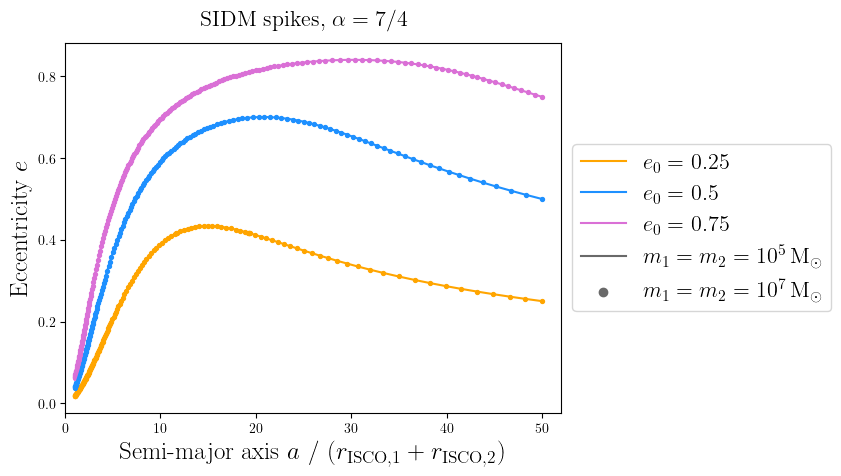

In [19]:
# Plot eccentricity vs. semi-major axis for SIDM

for i in range(len(e0)):
    plt.plot(ev_ecc_SIDM[2*i].a/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), ev_ecc_SIDM[2*i].e, label = '$e_0 = $ ' + str(e0[i]), color = color_list[i])
    plt.scatter(ev_ecc_SIDM[2*i+1].a/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), ev_ecc_SIDM[2*i+1].e, color = color_list[i], s=8)

plt.plot(20, 0.5, label=r"$m_1 = m_2 = 10^5 \, \mathrm{M_\odot}$ ", linestyle="solid", color="dimgrey")
plt.scatter(100, 0.5, label=r"$m_1 = m_2 = 10^7 \, \mathrm{M_\odot}$ ", color="dimgrey")   

plt.xlim(0,52)

plt.suptitle(r"SIDM spikes, $\alpha = 7/4$", y=0.95, fontsize=16)
plt.legend(loc="center left",  bbox_to_anchor=(1, 0.5), fontsize=16); plt.xlabel("Semi-major axis $a$ / ($r_{\mathrm{ISCO,1}}+r_{\mathrm{ISCO,2}}$)", fontsize=18); plt.ylabel("Eccentricity $e$", fontsize=18)
plt.show()

In [20]:
j = 0                                                             # Choose mass
sp = sp_CDM_list[j]
a0 = 50. * (sp.r_isco_1()+sp.r_isco_2())
e0 = np.array([0.25, 0.5])

a_fin = sp.r_isco_1()+sp.r_isco_2()

ev_ecc_CDM_ = []
ev_ecc_SIDM_ = []

for i in e0:
    ev_ecc_CDM_.append(SMBHBpy.inspiral.Classic.Evolve(sp_CDM_list[j], a0, e_0=i,  a_fin = a_fin))
    ev_ecc_SIDM_.append(SMBHBpy.inspiral.Classic.Evolve(sp_SIDM_list[fix_slope_index][j], a0, e_0=i,  a_fin = a_fin))

Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.25  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11
A termination event occurred.
 -> Evolution took 3.0683s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.25  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11
A termination event occurred.
 -> Evolution took 2.5626s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.5  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11
A termination event occurred.
 -> Evolution took 7.3550s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.5  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-11
A termination event occurred.
 -> Evolution took 3.6946s


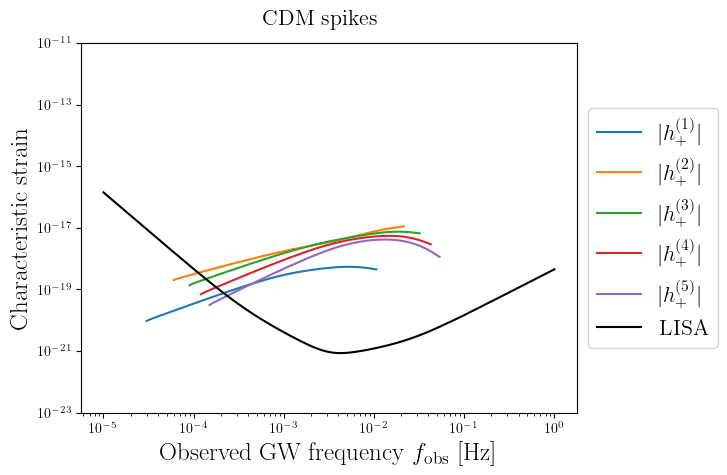

In [21]:
# Plot the first five harmonics for e0 = e0[p] and CDM spikes
n_comp = 5
p = 0                                     # Select initial eccentricity

wfs_CDM = [SMBHBpy.waveform.h_n(n, sp_CDM_list[j], ev_ecc_CDM_[p], acc=1e-13) for n in range(1, n_comp+1)]

for i in range(len(wfs_CDM)):
    plt.loglog(wfs_CDM[i][0]/c.hz_to_invpc, 2.*wfs_CDM[i][0]*np.abs(wfs_CDM[i][1]), label=r"$|h^{(" + str(i+1) + ")}_+|$")

# LISA:    
Lisa = SMBHBpy.detector.Lisa()
f_gw_LISA = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 1000)
plt.loglog(f_gw_LISA/c.hz_to_invpc, Lisa.NoiseStrain(f_gw_LISA), label='LISA', color = "black")
plt.suptitle("CDM spikes", y=0.95, fontsize=16)    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16); plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=18); plt.ylabel("Characteristic strain", fontsize=18); plt.ylim(bottom=1e-23, top=1e-11); plt.show()

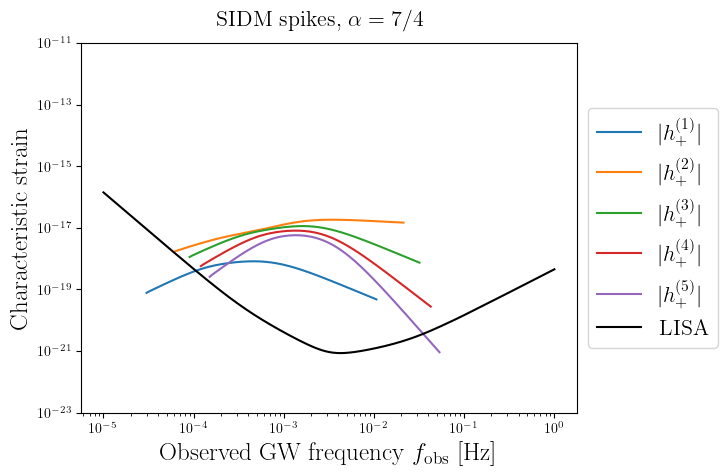

In [22]:
# Plot the first five harmonics for e0 = e0[p] and SIDM spikes
n_comp = 5
p = 0

wfs_SIDM = [SMBHBpy.waveform.h_n(n, sp_SIDM_list[fix_slope_index][j], ev_ecc_SIDM_[p], acc=1e-13) for n in range(1, n_comp+1)]

for i in range(len(wfs_SIDM)):
    plt.loglog(wfs_SIDM[i][0]/c.hz_to_invpc, 2.*wfs_SIDM[i][0]*np.abs(wfs_SIDM[i][1]), label=r"$|h^{(" + str(i+1) + ")}_+|$")
plt.suptitle(r"SIDM spikes, $\alpha = 7/4$", y=0.95, fontsize=16)
plt.loglog(f_gw_LISA/c.hz_to_invpc, Lisa.NoiseStrain(f_gw_LISA), label='LISA', color = "black")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16); plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=18); plt.ylabel("Characteristic strain", fontsize=18); plt.ylim(bottom=1e-23, top=1e-11); plt.show()

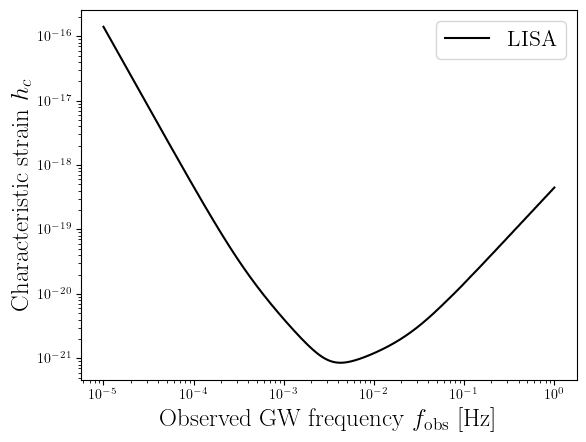

In [23]:
# LISA's sensitivity curve (https://arxiv.org/pdf/1803.01944)
Lisa = SMBHBpy.detector.Lisa()
f_gw_LISA = np.logspace(np.log10(Lisa.Bandwith()[0]), np.log10(Lisa.Bandwith()[1]), 1001)
plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=18); plt.ylabel("Characteristic strain $h_c$", fontsize=18)
plt.loglog(f_gw_LISA/c.hz_to_invpc, Lisa.NoiseStrain(f_gw_LISA), label='LISA', color = "black")
plt.legend(fontsize=16); plt.show()

C:\Users\matthias\Anaconda\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in D_L (vectorized)
  outputs = ufunc(*inputs)


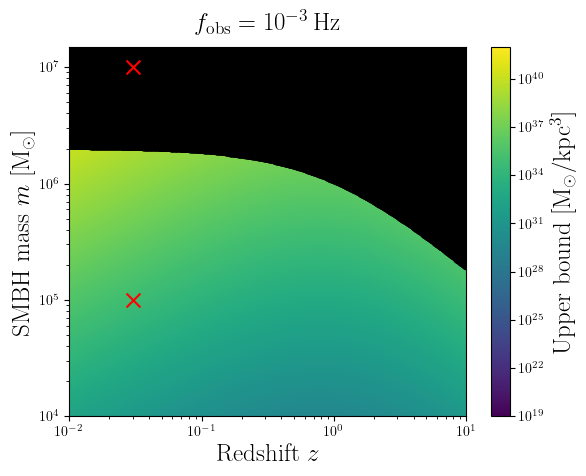

In [24]:
iota = np.pi/2                                                    # Inclination angle
Coulomb_log = 10                                                  # Coulomb logarithm

mass_array = np.array([10**5,10**7])*c.solar_mass_to_pc           # SMBHB masses (for equal-mass binaries)
z = 0.03                                                          # Redshift

# Function that calculates the upper limit for the matter density in M_sun/kpc^3
def rho_upper(z,d,m,f_obs,h_c_LISA_f_obs):
    A = 1./3.*1./2**(2./3.)*1./(Coulomb_log)*((1+(np.cos(iota))**2)/d)**2*((1+z)**16*m**10*np.pi**4)**(1./3.)
    B = 1./5.*1./(Coulomb_log)*(2**8*(1+z)**11*m**5*np.pi**8)**(1./3.)
    return (A*f_obs**(10./3.)/(h_c_LISA_f_obs**2)-B*f_obs**(11./3.))/c.solar_mass_to_pc*1e9
    
D_L_vec = np.vectorize(D_L)
N_fine = 700
m_ = np.logspace(4,7.2,int(N_fine))*c.solar_mass_to_pc
z_ = np.logspace(-2,1,int(N_fine))

M, Z = np.meshgrid(m_, z_)
d_ = D_L_vec(Z)

# Reference frequencies + corresponding characteristic strains: (depends on the line np.logspace(np.log10(Lisa.Bandwith()[0]), np.log10(Lisa.Bandwith()[1]), 1001))
# 1e-5, 1e-4, 1e-3 and 1e-2 Hz
f_obs_ref = [f_gw_LISA[0], f_gw_LISA[200], f_gw_LISA[400], f_gw_LISA[600]]     # To get the correct frequencies here, the definition of f_gw_LISA made above is essential
f_obs_ref_label = ["10^{-5}", "10^{-4}", "10^{-3}", "10^{-2}"]
h_c_LISA_ref = [Lisa.NoiseStrain(f_gw_LISA)[0],Lisa.NoiseStrain(f_gw_LISA)[200],Lisa.NoiseStrain(f_gw_LISA)[400],Lisa.NoiseStrain(f_gw_LISA)[400]]

r_iscos = 2*6*M
f_iscos = 1/(np.pi*(1+Z))*np.sqrt(2*M/r_iscos**3)

chose_index = 2

mask_iscos = f_iscos > f_obs_ref[chose_index]
M_filtered = np.where(mask_iscos, M, np.nan) 
Z_filtered = np.where(mask_iscos, Z, np.nan)
d_filtered = D_L_vec(Z_filtered)

rho_max = rho_upper(Z_filtered,d_filtered,M_filtered,f_obs_ref[chose_index],h_c_LISA_ref[chose_index])

scatter = plt.scatter(Z.flatten(), M.flatten() / c.solar_mass_to_pc, c=rho_max.flatten(), cmap='viridis', norm=LogNorm(vmin=1e19, vmax=1e42)) 
colorbar = plt.colorbar(scatter)
colorbar.set_label('Upper bound  [$\mathrm{M_\odot}$/kpc$^3$]', fontsize=18)
plt.title(f"$f_\mathrm{{obs}} = {f_obs_ref_label[chose_index]}\,\mathrm{{Hz}}$", fontsize = 18, pad=12)

plt.xlabel("Redshift $z$", fontsize = 18)
plt.ylabel("SMBH mass $m$ [$\mathrm{M_\odot}$]", fontsize = 18)
plt.xscale("log")
plt.yscale("log")
plt.ylim(m_[0]/c.solar_mass_to_pc, 1.5*1e7)
plt.xlim(z_[0],z_[-1])

zero_mask = rho_max <= 0
plt.scatter(Z[zero_mask], M[zero_mask] / c.solar_mass_to_pc, color='grey')
mask_iscos_ = f_iscos < f_obs_ref[chose_index]
plt.scatter(Z[mask_iscos_], M[mask_iscos_] / c.solar_mass_to_pc, color='black')

plt.scatter(z, mass_array[0]/c.solar_mass_to_pc, color = "red", s = 100, marker='x')
plt.scatter(z, mass_array[1]/c.solar_mass_to_pc, color = "red", s = 100, marker='x')
plt.show()

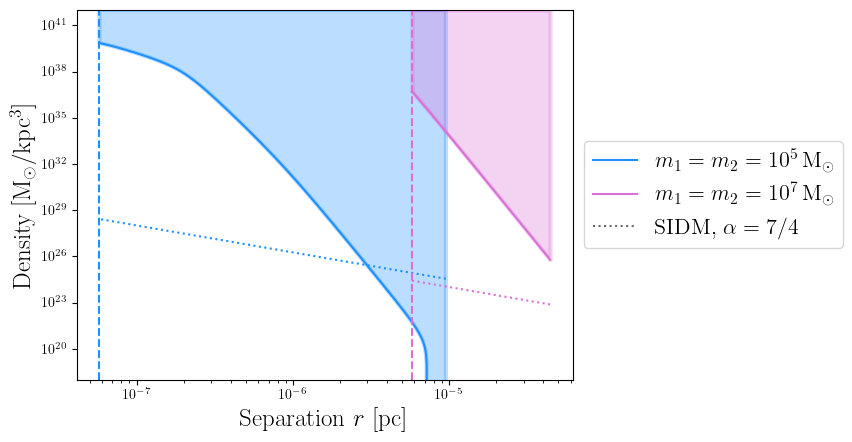

In [25]:
# Upper limit for the matter density as a function of separation using LISA's sensitivity curve
sigma = 200 *10**3*c.m_to_pc/(c.s_to_pc)                          # Velocity dispersion of the host galaxy-bulge [km/s]
D = D_L(z)                                                        # Luminosity distance

smallest_exponent = 5                                              # Parameter for plotting (corresponds to the smallest exponent in the mass array)
h_c_LISA = Lisa.NoiseStrain(f_gw_LISA)                             # h_c of LISA's sensitivity curve
f_LISA = f_gw_LISA                                                 # LISA's frequency range

color = ["dodgerblue", "orchid"]
color_fill = color

#####

r_isco_array = 2*6*mass_array                                        # ISCO for each SMBH

for i in range(len(mass_array)):
    m = mass_array[i]
    r = (2*m/(f_LISA*(1+z)*np.pi)**2)**(1./3.)                     # Relation between f_obs and r for circular orbits
    r_lim = []
    index = []
    rho_DM_lim = []
    for j in range(len(r)):                                        # Is needed for computing the matter density only up to ISCO
        if r[j]>=r_isco_array[i]:                                  
            r_lim.append(r[j])
            index.append(j)
    exponent = smallest_exponent+i*2
    r_sp = 0.2*m/sigma**2                                          # Parameter for the spike size
    rho_sp_SIDM = (3-7/4)*0.2**(3-7/4)*m/(2*np.pi*r_sp**3)         # Normalization density for SIDM spike
    rho_SIDM = rho_sp_SIDM * (r_sp/r_lim)**(7/4)                   # SIDM spike density distribution
    for k in range(len(index)):
        if k >= min(index):
            rho_DM_lim.append(rho_upper(z,D,m,f_LISA[k],h_c_LISA[k]))
    # Plot the individual upper thresholds + CDM and SIDM spike density distributions for comparison
    plt.loglog(r_lim,rho_DM_lim, color = color[i], label = f'$m_1 = m_2 = 10^{{{exponent}}}\, \mathrm{{M_\odot}}$')
    plt.loglog(r_lim,rho_SIDM/c.solar_mass_to_pc*1e9, linestyle = ':', color = color[i])
    plt.fill_between(r_lim, rho_DM_lim, 1e42, where=(1e42 >= np.array(rho_DM_lim)), facecolor=color_fill[i], edgecolor=color_fill[i], linewidth = 3, alpha=0.3)
    plt.axvline(x=r_isco_array[i], color=color[i], linestyle='--')   # Marks the position of the corresponding ISCO
    
plt.loglog(1e-6, 1e30, label=r"SIDM, $\alpha = 7/4$", linestyle=":", color="dimgrey")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
plt.xlabel("Separation $r$ [pc]", fontsize=18); plt.ylabel("Density  [$\mathrm{M_\odot}$/kpc$^3$]", fontsize=18)
plt.ylim(1e18,1e42)
plt.show()

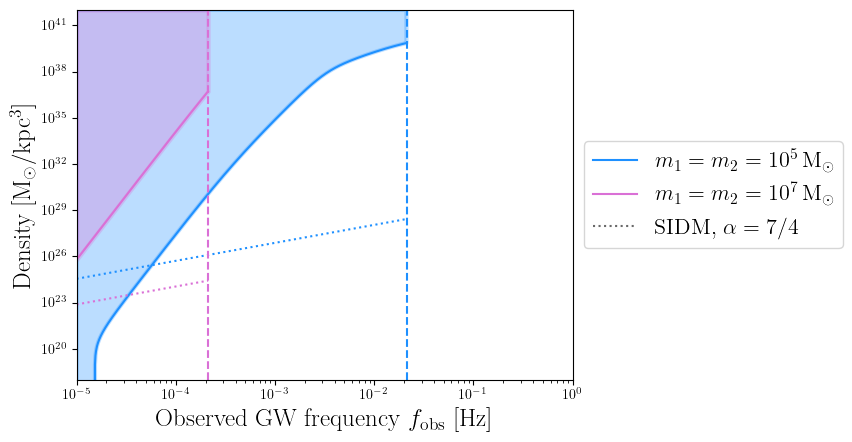

In [26]:
# Upper limit for the matter density as a function of GW frequency using LISA's sensitivity curve

for i in range(len(mass_array)):
    m = mass_array[i]
    r = (2*m/(f_LISA*(1+z)*np.pi)**2)**(1./3.)
    r_lim = []
    index = []
    rho_DM_lim = []
    f_LISA_lim=[]
    for j in range(len(r)):
        if r[j]>=r_isco_array[i]:
            f_LISA_lim.append(1/(np.pi*(1+z))*np.sqrt(2*m/(r[j])**3))
            r_lim.append(r[j])
            index.append(j)
    exponent = smallest_exponent+i*2
    r_sp = 0.2*m/sigma**2
    rho_sp_SIDM = (3-7/4)*0.2**(3-7/4)*m/(2*np.pi*r_sp**3)
    rho_SIDM = rho_sp_SIDM * (r_sp/r_lim)**(7/4)
    for k in range(len(index)):
        if k >= min(index):
            rho_DM_lim.append(rho_upper(z,D,m,f_LISA[k],h_c_LISA[k]))
    plt.loglog(np.array(f_LISA_lim)/c.hz_to_invpc,rho_DM_lim, color = color[i], label = f'$m_1 = m_2 = 10^{{{exponent}}}\, \mathrm{{M_\odot}}$')
    plt.loglog(np.array(f_LISA_lim)/c.hz_to_invpc,rho_SIDM/c.solar_mass_to_pc*1e9, linestyle = ':', color = color[i])
    plt.fill_between(np.array(f_LISA_lim)/c.hz_to_invpc, rho_DM_lim, 1e42, where=(1e42 >= np.array(rho_DM_lim)), facecolor=color_fill[i], edgecolor=color_fill[i], linewidth = 3, alpha=0.3)
    plt.axvline(x=1/(np.pi*(1+z))*np.sqrt(2*m/r_isco_array[i]**3)/c.hz_to_invpc, color=color[i], linestyle='--')
    
plt.loglog(1e-6, 1e30, label=r"SIDM, $\alpha = 7/4$", linestyle=":", color="dimgrey")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=18); plt.ylabel("Density  [$\mathrm{M_\odot}$/kpc$^3$]", fontsize=18)
plt.ylim(1e18,1e42)
plt.xlim(1e-5,1e0)
plt.show()